# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from shutil import copyfile
import numpy as np
import cv2
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.framework as ops
import tensorflow.contrib.layers as layers

In [4]:


# Reload initial, unchanged data after a training run.

copyfile('./traffic-signs-data/backup/train-backup.p', './traffic-signs-data/train.p')
copyfile('./traffic-signs-data/backup/test-backup.p', './traffic-signs-data/test.p')
copyfile('./traffic-signs-data/backup/valid-backup.p', './traffic-signs-data/valid.p')





training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


# # Split data into training and validation
# from sklearn.model_selection import train_test_split

# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape

# TODO: Number of validation examples
n_validation = X_valid.shape

# TODO: Number of testing examples.
n_test = X_test.shape

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = (34799, 32, 32, 3)
Number of testing examples = (12630, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

def show_samples(data):
    images = []

    index = np.random.randint(0, len(data), size=16)
    for i, idx in enumerate(index):
        images.append(data[idx].squeeze())

    fig = plt.figure(1, (16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 8),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for i in range(16):
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()
    
    return None

# show_samples(X_train)




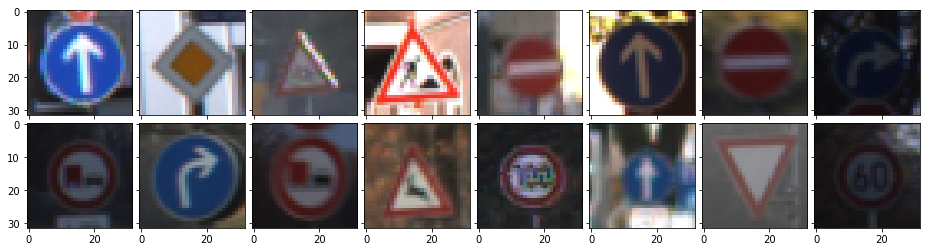

In [7]:
show_samples(X_train)

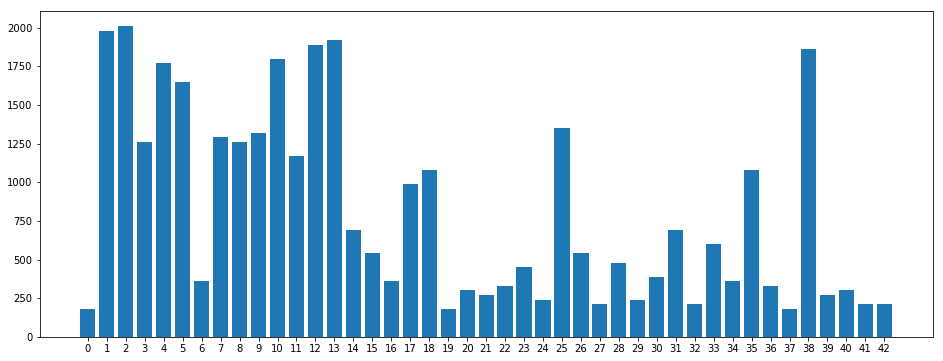

In [8]:

num_data_points = {}

for i in range(0, len(X_train)):
    cls = y_train[i]
    if cls in num_data_points:
        num_data_points[cls] += 1
#         num_data_points[cls][2] = i
    else:
        num_data_points[cls] = 1
#         num_data_points[cls][1] = i
        
        
# sum = 0
# for k, v in num_data_points.items():
#     print("{}: {}".format(k, v))
    
    
# print(num_data_points.values)
  


x = np.arange(n_classes)
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
plt.bar(x, list(num_data_points.values()))
plt.xticks(x, list(num_data_points.keys()))

plt.show()




## Generate More Data

### 1. Flipping

Idea and code from https://navoshta.com/traffic-signs-classification/

In [7]:
def flip_extend(X, y):
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

In [8]:
X_train, y_train = flip_extend(X_train, y_train)

print(X_train.shape, y_train.shape)

(59788, 32, 32, 3) (59788,)


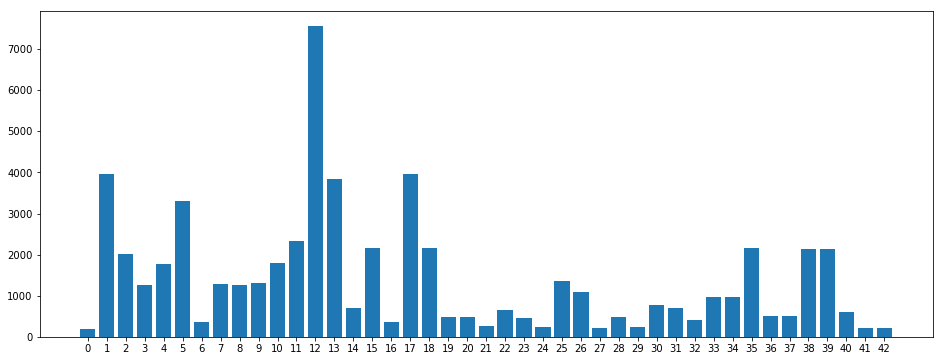

In [9]:
num_data_points = {}

for i in range(0, len(X_train)):
    cls = y_train[i]
    if cls in num_data_points:
        num_data_points[cls] += 1
    else:
        num_data_points[cls] = 1
        

x = np.arange(n_classes)
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
plt.bar(x, list(num_data_points.values()))
plt.xticks(x, list(num_data_points.keys()))

plt.show()



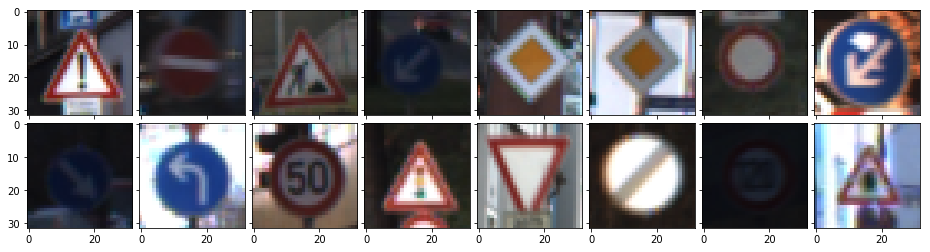

In [10]:
show_samples(X_train)

In [11]:
target_value = 3000

def show_gap(data_counts, target_value):
    gap_dict = {}
    for k, v in data_counts.items():
        gap_dict[k] = list(divmod(target_value, v))
    
    return gap_dict


In [12]:
gaps = show_gap(num_data_points, target_value)

In [13]:
for k, v in gaps.items():
    print("{}: {}".format(k, v))

0: [16, 120]
1: [0, 3000]
2: [1, 990]
3: [2, 480]
4: [1, 1230]
5: [0, 3000]
6: [8, 120]
7: [2, 420]
8: [2, 480]
9: [2, 360]
10: [1, 1200]
11: [1, 660]
12: [0, 3000]
13: [0, 3000]
14: [4, 240]
15: [1, 840]
16: [8, 120]
17: [0, 3000]
18: [1, 840]
19: [6, 120]
20: [6, 120]
21: [11, 30]
22: [4, 360]
23: [6, 300]
24: [12, 120]
25: [2, 300]
26: [2, 840]
27: [14, 60]
28: [6, 120]
29: [12, 120]
30: [3, 660]
31: [4, 240]
32: [7, 60]
33: [3, 123]
34: [3, 123]
35: [1, 840]
36: [5, 450]
37: [5, 450]
38: [1, 870]
39: [1, 870]
40: [5, 0]
41: [14, 60]
42: [14, 60]


### 2. Geometric Transformations

In [14]:
def rotate(image):
    rows, cols, _ = image.shape
    mid_row = rows // 2
    mid_col = cols // 2
    delta = rows // 5
    
    center_x = np.random.randint(mid_row - delta, mid_row + delta)
    center_y = np.random.randint(mid_col - delta, mid_col + delta)
    
    angle = np.random.randint(-20, 20)
    
#     print(center_x, center_y, angle)
    
    M = cv2.getRotationMatrix2D((center_y,center_x),angle,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst


def mirror(image):
    return cv2.flip(image, 1)


def warp(image):
    rows, cols, _ = image.shape
    
    delta = rows // 8
    
    p1 = (8, 8)
    p2 = (24, 6)
    p3 = (16, 24)
    
    pts1 = np.float32([[8,8],
                       [24,6],
                       [16,24]
                      ])
    
    warping_deltas = np.random.randint(-delta, delta, (3, 2))
    
    wp1 = np.float32([x+y for x, y in zip(p1, warping_deltas[0])])
    wp2 = np.float32([x+y for x, y in zip(p2, warping_deltas[1])])
    wp3 = np.float32([x+y for x, y in zip(p3, warping_deltas[2])])
    
    pts2 = np.float32([wp1, wp2, wp3])
    
    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(image,M,(cols,rows))
    
    return dst

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (3,3), 0)


def motion_blur(image):
    size = 3

    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    # applying the kernel to the input image
    output = cv2.filter2D(image, -1, kernel_motion_blur)
    
    return output


def scale(image):   
    rows,cols,_ = image.shape
    px = np.random.randint(-2,2)
    
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    dst = cv2.warpPerspective(image,M,(rows,cols))   
#     print(dst.shape)


#     dst = dst[:,:,np.newaxis]   
#     print(dst.shape)
    return dst

def lighting(image):
    image1 = cv2.cvtColor(np.uint8(image),cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [15]:
def generate_random_transform(image):
    coin = np.random.randint(3)
    
    if (coin == 0):
        gen_img = rotate(image)
    elif (coin == 1):
        gen_img = scale(image)
    else:
        gen_img = warp(image)
        
    return gen_img

In [17]:
# for i in range(10):
#     index = random.randint(0, len(X_train))
#     image = X_train[index].squeeze()

#     plt.figure(figsize=(1,1))
#     plt.imshow(generate_random_transform(image))

### 2.1 Fill up classes to make each have about the same, much larger number of images

In [20]:
def fill_up_classes(X, y, gap_dict):
    X_new = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_new = np.empty([0], dtype = y.dtype)
    
    print("Generating {} new images...".format((target_value * n_classes) - y_train.shape[0]))

    
    for i in range(len(X)):            
        if (i % 500 == 0):
            print("{} of {} seed images done...".format(i, len(X)))
            
        
        cls = y[i]
        n_transforms = gap_dict[cls][0] - 1
        
        if (n_transforms < 0):
#             print(X_new.shape, X[i].shape)
            v = np.expand_dims(X[i], axis=0)
            l = np.expand_dims(y[i], axis=0)
            X_new = np.append(X_new, v, axis = 0)
            y_new = np.append(y_new, l, axis = 0)
            continue
        
#         # passing over classes that are already full and which we have already copied over
#         if (gap_dict[cls][0] == 0):
#             continue
        
#         print("i:{}, n_transforms: {}".format(i, n_transforms))
        if (gap_dict[cls][1] > 0):
#             print(gap_dict[cls][1])
            n_transforms += 1
            gap_dict[cls][1] -= 1
#             print(gap_dict[cls][1])
            
        if (n_transforms == 0):
#             print(X_new.shape, X[i].shape)
            v = np.expand_dims(X[i], axis=0)
            l = np.expand_dims(y[i], axis=0)
#             print(v.shape)
            X_new = np.append(X_new, v, axis = 0)
            y_new = np.append(y_new, l, axis = 0)
            continue
        else:
            X_temp = np.full([n_transforms + 1, X.shape[1], X.shape[2], X.shape[3]], X[i], dtype = X.dtype)
            y_temp = np.full([n_transforms + 1], y[i], dtype = y.dtype) 
            for j in range(len(X_temp) - 1):
                X_temp[j] = generate_random_transform(X_temp[j])
                
            X_new = np.append(X_new, X_temp, axis = 0)
            y_new = np.append(y_new, y_temp, axis = 0)
            
    return (X_new, y_new)
            
        
# if n_transforms == -1:
#     X_new = np.append(X_new, X[i:i+num_data_points[cls], :, :, :], axis = 0)
# elif n_transforms == 0:
#     
    

In [ ]:
c0 = num_data_points[0]
g0 = gaps[0]

c1 = num_data_points[1]
g1 = gaps[1]

print(c0, g0)
print(c1, g1)




In [ ]:
X_t = X_train[0:500, :, :, :]
y_t = y_train[0:500]

In [ ]:
print(X_t.shape, y_t.shape)

print(gaps[20][1])

In [21]:
import time

start_time = time.time()

X_extended, y_extended =  fill_up_classes(X_train, y_train, gaps)

print("Duration: {} sec".format(time.time() - start_time))

Generating 69212 new images...
0 of 59788 seed images done...
500 of 59788 seed images done...
1000 of 59788 seed images done...
1500 of 59788 seed images done...
2000 of 59788 seed images done...
2500 of 59788 seed images done...
3000 of 59788 seed images done...
3500 of 59788 seed images done...
4000 of 59788 seed images done...
4500 of 59788 seed images done...
5000 of 59788 seed images done...
5500 of 59788 seed images done...
6000 of 59788 seed images done...
6500 of 59788 seed images done...
7000 of 59788 seed images done...
7500 of 59788 seed images done...
8000 of 59788 seed images done...
8500 of 59788 seed images done...
9000 of 59788 seed images done...
9500 of 59788 seed images done...
10000 of 59788 seed images done...
10500 of 59788 seed images done...
11000 of 59788 seed images done...
11500 of 59788 seed images done...
12000 of 59788 seed images done...
12500 of 59788 seed images done...
13000 of 59788 seed images done...
13500 of 59788 seed images done...
14000 of 5978

(136500, 32, 32, 3) (136500,)
90064 27
[16, 0] [0, 3000]
1
1


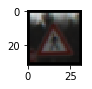

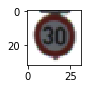

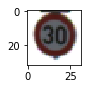

In [23]:
print(X_extended.shape, y_extended.shape)

index = random.randint(0, len(X_extended))
image = X_extended[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)

print(index, y_extended[index])
print(gaps[0], gaps[1])
# zeros = list(filter(lambda x: x == 0, y_t))
# ones = list(filter(lambda x: x == 1, y_t))

# zerost = list(filter(lambda x: x == 0, y_extended))
# onest = list(filter(lambda x: x == 1, y_extended))


# print(len(zeros), len(zerost))
# print(len(ones), len(onest))


plt.figure(figsize=(1,1))
plt.imshow(X_extended[4999].squeeze())
print(y_extended[4999])

plt.figure(figsize=(1,1))
plt.imshow(X_extended[5000].squeeze())
print(y_extended[5000])


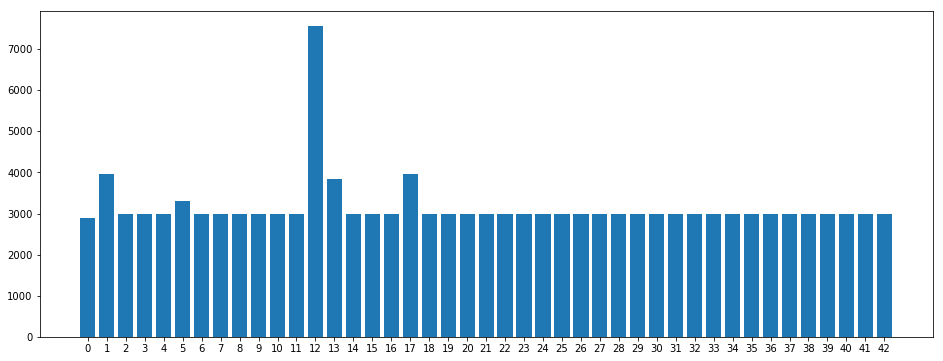

In [24]:
num_data_points = {}

for i in range(0, len(X_extended)):
    cls = y_extended[i]
    if cls in num_data_points:
        num_data_points[cls] += 1
    else:
        num_data_points[cls] = 1
        

x = np.arange(n_classes)
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
plt.bar(x, list(num_data_points.values()))
plt.xticks(x, list(num_data_points.keys()))

plt.show()

# Normalize and Equalize Data

In [9]:
# Normalize and Equalize: Functions

from skimage import exposure
from skimage import img_as_float

def preprocess_image(X):

    X = (X / 255.).astype(np.float32)
        
    X = img_as_float(exposure.equalize_adapthist(X))
    
    return X



/Users/dragosilinca/anaconda/envs/carnd/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


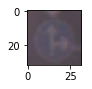

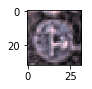

In [26]:
index = random.randint(0, len(X_extended))
image1 = X_extended[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image1)

plt.figure(figsize=(1,1))
plt.imshow(preprocess_image(image1))

In [ ]:
X_p = np.empty([0, X_extended.shape[1], X_extended.shape[2], X_extended.shape[3]], dtype = X_extended.dtype)

print(X_p.shape)

for i in range(7):
    plt.figure(figsize=(1,1))
    image = preprocess_image(X_extended[i])
    plt.imshow(image)
    image = np.expand_dims(image, axis=0)
    X_p = np.append(X_p, image, axis=0)
    
index = random.randint(0, len(X_p))
image = X_p[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)



In [10]:

def process_collection(X):
    start_time = time.time()
    
    X_processed = np.array(np.array(list(map(preprocess_image, X)), dtype=np.float32))
    
    print("Duration: {} sec".format(time.time() - start_time))  
    return X_processed
    

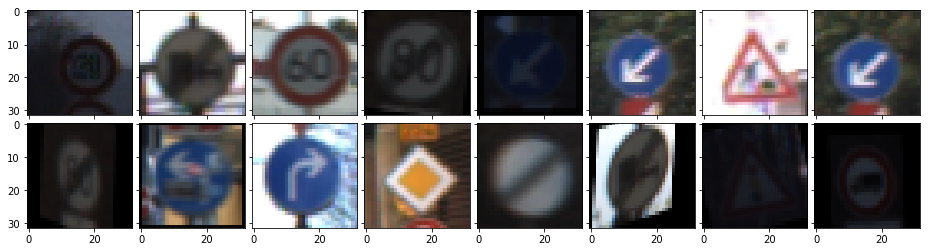

In [42]:
show_samples(X_extended)

In [54]:
import os
# Save the data for easy access
pickle_file = './traffic-signs-data/augmented/fulldata.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_features': X_extended,
                    'train_labels': y_extended,
                    'valid_features': X_valid,
                    'valid_labels': y_valid,
                    'test_features': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


/Users/dragosilinca/anaconda/envs/carnd/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Duration: 0.8991608619689941 sec


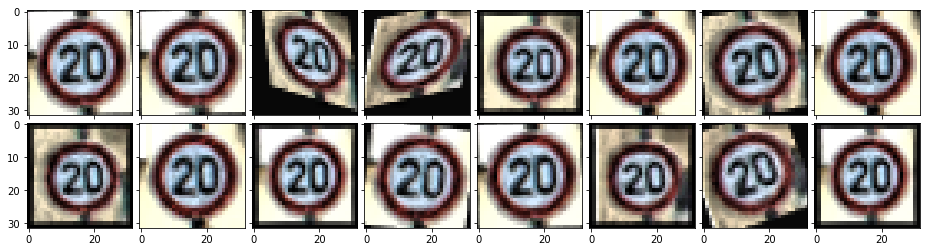

In [48]:
X_TEMP = X_extended[0:100, :, :, :]

X_V = process_collection(X_TEMP)

show_samples(X_V)


## Normalize Train, Validation and Test Sets

In [11]:
# Load data from pickle file

input_file = './traffic-signs-data/augmented/fulldata.p'

with open(input_file, mode='rb') as f:
    data = pickle.load(f)
    
X_train_temp, y_train_temp = data['train_features'], data['train_labels']
X_valid_temp, y_valid_temp = data['valid_features'], data['valid_labels']
X_test_temp, y_test_temp = data['test_features'], data['test_labels']

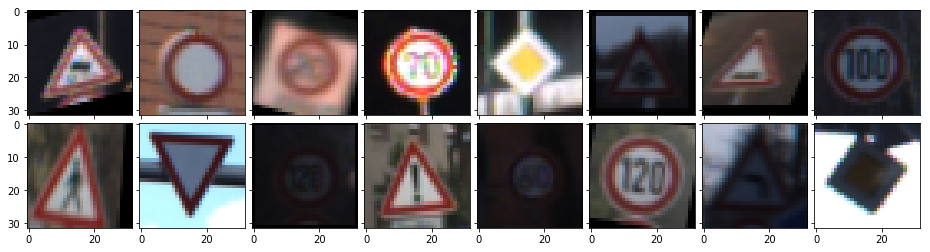

In [12]:
show_samples(X_train_temp)

(136500, 32, 32, 3) (136500,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


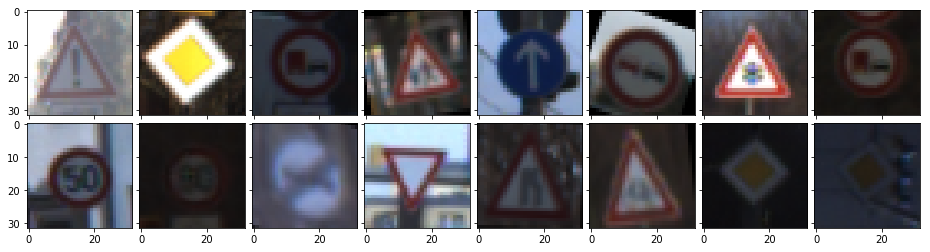

In [13]:
print(X_train_temp.shape, y_train_temp.shape)
print(X_valid_temp.shape, y_valid_temp.shape)
print(X_test_temp.shape, y_test_temp.shape)

show_samples(X_train_temp)

In [14]:
X_train = process_collection(X_train_temp)
X_valid = process_collection(X_valid_temp)
X_test = process_collection(X_test_temp)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Duration: 2213.887010574341 sec
Duration: 70.87137341499329 sec
Duration: 202.99574303627014 sec


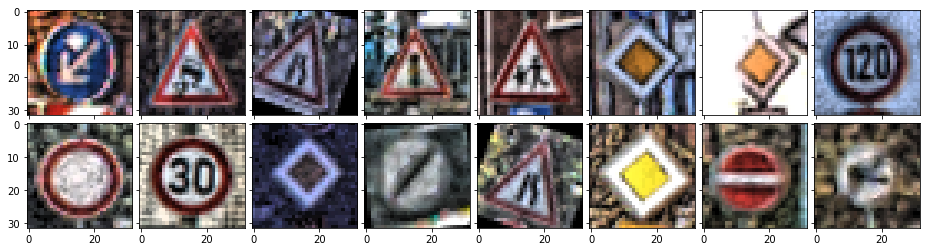

(136500, 32, 32, 3)


In [15]:
show_samples(X_train)
print(X_train.shape)

In [16]:
y_train = y_train_temp
y_valid = y_valid_temp
y_test = y_test_temp

In [18]:
import os
pickle_file = './traffic-signs-data/augmented/normalized.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_features': X_train,
                    'train_labels': y_train,
                    'valid_features': X_valid,
                    'valid_labels': y_valid,
                    'test_features': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [19]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(136500, 32, 32, 3) (136500,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


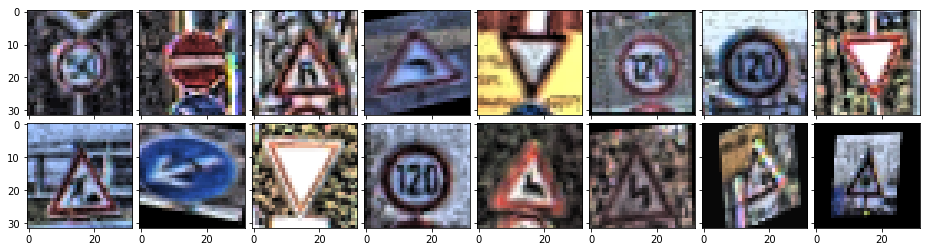

In [90]:
# y_train = y_train_temp
# y_valid = y_valid_temp
# y_test = y_test_temp

show_samples(X_train)

## Shuffle The Data

In [20]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Model Architecture

In [21]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 50
BATCH_SIZE = 256
keep_prob = 0.5

In [22]:
from tensorflow.contrib.layers import flatten


def model_net(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    l1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    l2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    l3 = x

    l2flat = flatten(l2)
    
    xflat = flatten(x)
    
    x = tf.concat(1, [xflat, l2flat])
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits


### Train, Validate and Test the Model

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [24]:
rate = 0.001

# logits = LeNet(x)
logits = model_net(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
import time
start_time = time.time()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()

    for i in range(EPOCHS):
        q = 0
        num_batches = num_examples // BATCH_SIZE
        X_train, y_train = shuffle(X_train, y_train)
        b_time = time.time()
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
            if (q % 50 == 0):
                print("BATCH {} of {} ... done in {:.3f} sec with LOSS: {}".format(q+1, num_batches, (time.time() - b_time), loss))
                b_time = time.time()
            q += 1
            
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './inception')
    print("Model saved")
    
    print("--- {:.3f} seconds ---".format((time.time() - start_time)))



Training...

BATCH 1 of 533 ... done in 1.602 sec with LOSS: 3.814554214477539
BATCH 51 of 533 ... done in 1.380 sec with LOSS: 2.6499569416046143
BATCH 101 of 533 ... done in 1.377 sec with LOSS: 1.5483266115188599
BATCH 151 of 533 ... done in 1.376 sec with LOSS: 1.1970241069793701
BATCH 201 of 533 ... done in 1.374 sec with LOSS: 1.0310148000717163
BATCH 251 of 533 ... done in 1.375 sec with LOSS: 0.6842658519744873
BATCH 301 of 533 ... done in 1.377 sec with LOSS: 0.750196635723114
BATCH 351 of 533 ... done in 1.373 sec with LOSS: 0.6056040525436401
BATCH 401 of 533 ... done in 1.377 sec with LOSS: 0.5931411981582642
BATCH 451 of 533 ... done in 1.376 sec with LOSS: 0.5849761962890625
BATCH 501 of 533 ... done in 1.376 sec with LOSS: 0.49513575434684753
EPOCH 1 ...
Validation Accuracy = 0.872

BATCH 1 of 533 ... done in 0.079 sec with LOSS: 0.46575629711151123
BATCH 51 of 533 ... done in 1.376 sec with LOSS: 0.3578824996948242
BATCH 101 of 533 ... done in 1.376 sec with LOSS: 0.354

BATCH 101 of 533 ... done in 1.378 sec with LOSS: 0.05435114726424217
BATCH 151 of 533 ... done in 1.377 sec with LOSS: 0.06054161116480827
BATCH 201 of 533 ... done in 1.377 sec with LOSS: 0.09282013773918152
BATCH 251 of 533 ... done in 1.376 sec with LOSS: 0.10865441709756851
BATCH 301 of 533 ... done in 1.377 sec with LOSS: 0.05077037587761879
BATCH 351 of 533 ... done in 1.378 sec with LOSS: 0.07657875120639801
BATCH 401 of 533 ... done in 1.376 sec with LOSS: 0.07861185818910599
BATCH 451 of 533 ... done in 1.378 sec with LOSS: 0.06131856516003609
BATCH 501 of 533 ... done in 1.377 sec with LOSS: 0.057885706424713135
EPOCH 11 ...
Validation Accuracy = 0.946

BATCH 1 of 533 ... done in 0.078 sec with LOSS: 0.051441214978694916
BATCH 51 of 533 ... done in 1.376 sec with LOSS: 0.08280763775110245
BATCH 101 of 533 ... done in 1.374 sec with LOSS: 0.07822659611701965
BATCH 151 of 533 ... done in 1.378 sec with LOSS: 0.090979665517807
BATCH 201 of 533 ... done in 1.376 sec with LOSS: 0

BATCH 201 of 533 ... done in 1.378 sec with LOSS: 0.039204422384500504
BATCH 251 of 533 ... done in 1.376 sec with LOSS: 0.030193693935871124
BATCH 301 of 533 ... done in 1.377 sec with LOSS: 0.025553595274686813
BATCH 351 of 533 ... done in 1.378 sec with LOSS: 0.014900409616529942
BATCH 401 of 533 ... done in 1.377 sec with LOSS: 0.05532751604914665
BATCH 451 of 533 ... done in 1.377 sec with LOSS: 0.01809966191649437
BATCH 501 of 533 ... done in 1.377 sec with LOSS: 0.030913744121789932
EPOCH 21 ...
Validation Accuracy = 0.961

BATCH 1 of 533 ... done in 0.079 sec with LOSS: 0.08884280920028687
BATCH 51 of 533 ... done in 1.376 sec with LOSS: 0.02503281831741333
BATCH 101 of 533 ... done in 1.374 sec with LOSS: 0.030566921457648277
BATCH 151 of 533 ... done in 1.376 sec with LOSS: 0.009357071481645107
BATCH 201 of 533 ... done in 1.376 sec with LOSS: 0.020884055644273758
BATCH 251 of 533 ... done in 1.375 sec with LOSS: 0.01509647537022829
BATCH 301 of 533 ... done in 1.372 sec with

BATCH 251 of 533 ... done in 1.378 sec with LOSS: 0.02134339138865471
BATCH 301 of 533 ... done in 1.378 sec with LOSS: 0.012603111565113068
BATCH 351 of 533 ... done in 1.377 sec with LOSS: 0.021911289542913437
BATCH 401 of 533 ... done in 1.377 sec with LOSS: 0.015859436243772507
BATCH 451 of 533 ... done in 1.376 sec with LOSS: 0.01779533363878727
BATCH 501 of 533 ... done in 1.381 sec with LOSS: 0.03479612618684769
EPOCH 31 ...
Validation Accuracy = 0.955

BATCH 1 of 533 ... done in 0.078 sec with LOSS: 0.019467322155833244
BATCH 51 of 533 ... done in 1.376 sec with LOSS: 0.016457609832286835
BATCH 101 of 533 ... done in 1.376 sec with LOSS: 0.018321197479963303
BATCH 151 of 533 ... done in 1.374 sec with LOSS: 0.02479955181479454
BATCH 201 of 533 ... done in 1.376 sec with LOSS: 0.05141891911625862
BATCH 251 of 533 ... done in 1.375 sec with LOSS: 0.03238307684659958
BATCH 301 of 533 ... done in 1.380 sec with LOSS: 0.02055525593459606
BATCH 351 of 533 ... done in 1.380 sec with L

BATCH 301 of 533 ... done in 1.374 sec with LOSS: 0.01591775007545948
BATCH 351 of 533 ... done in 1.376 sec with LOSS: 0.026320673525333405
BATCH 401 of 533 ... done in 1.380 sec with LOSS: 0.08641637116670609
BATCH 451 of 533 ... done in 1.377 sec with LOSS: 0.04906323179602623
BATCH 501 of 533 ... done in 1.378 sec with LOSS: 0.01449502818286419
EPOCH 41 ...
Validation Accuracy = 0.955

BATCH 1 of 533 ... done in 0.079 sec with LOSS: 0.012157343327999115
BATCH 51 of 533 ... done in 1.374 sec with LOSS: 0.026564981788396835
BATCH 101 of 533 ... done in 1.375 sec with LOSS: 0.007285320200026035
BATCH 151 of 533 ... done in 1.376 sec with LOSS: 0.035998862236738205
BATCH 201 of 533 ... done in 1.377 sec with LOSS: 0.02640400640666485
BATCH 251 of 533 ... done in 1.377 sec with LOSS: 0.00912371464073658
BATCH 301 of 533 ... done in 1.377 sec with LOSS: 0.029379425570368767
BATCH 351 of 533 ... done in 1.376 sec with LOSS: 0.033486250787973404
BATCH 401 of 533 ... done in 1.375 sec with 

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.945


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

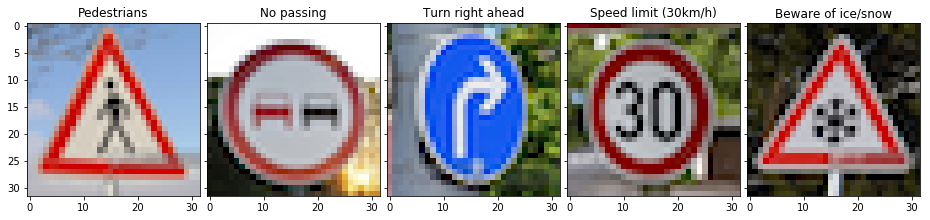

In [28]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import csv
import os

new_images = []
new_labels = np.array([27, 9, 33, 1, 30])


for file in os.listdir('./new_images'):
    if file.endswith(".png"):
        temp_img = cv2.imread('./new_images/'+ str(file), cv2.IMREAD_COLOR)
        new_images.append(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
        
signnames = {}
with open('signnames.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(spamreader):
        if i == 0:
            pass
        else:
            signnames[np.int(row[0])] = row[1]
        
# for k, v in signnames.items():
#     print("{}: {}".format(k, v))
    

fig = plt.figure(1, (16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for i in range(5):
    grid[i].set_title(signnames[new_labels[i]], fontdict=None, loc='center', color = "k")
    grid[i].imshow(new_images[i])  # The AxesGrid object work as a list of axes.

plt.show()





### Predict the Sign Type for Each Image

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Duration: 0.0840296745300293 sec


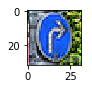

In [29]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Pre-processing

signs = process_collection(new_images)
    
plt.figure(figsize=(1,1))
plt.imshow(signs[2])

In [30]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(signs, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    lv = sess.run(logits, feed_dict={x: signs})
    soft_vector = sess.run(tf.nn.softmax(lv))

Test Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

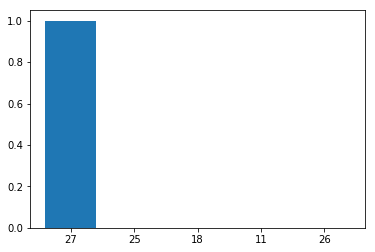

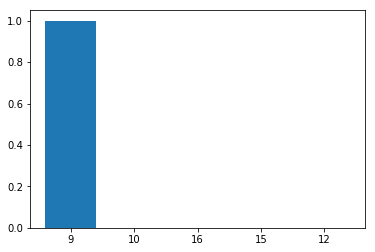

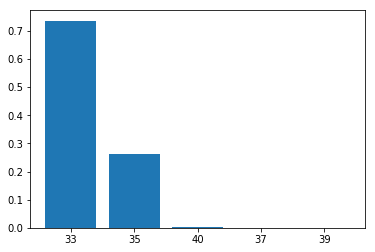

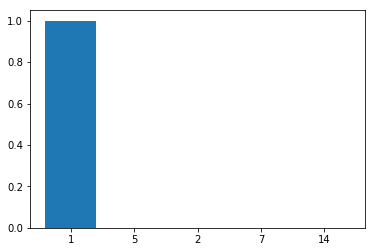

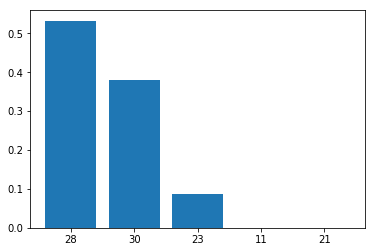

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(soft_vector), k=5))

v = top5.values
i = top5.indices

for k in range(5):
    x = np.arange(5)
    # money = [1.5e5, 2.5e6, 5.5e6, 2.0e7]
    fig, ax = plt.subplots()
    plt.bar(x, v[k])
    plt.xticks(x, i[k])
    plt.show()